<a href="https://colab.research.google.com/github/semaHbo/job-clustering-salary-prediction/blob/main/model_gbt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar -xzf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark


In [20]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("GBT_Model").getOrCreate()


In [21]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls /content/drive/MyDrive/datasets


archive.zip  test_df.parquet  train_df.parquet


In [22]:
train_df = spark.read.parquet("/content/drive/MyDrive/datasets/train_df.parquet")
test_df = spark.read.parquet("/content/drive/MyDrive/datasets/test_df.parquet")


In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Modeli tanımlama
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="Log_Maas_USD",
    predictionCol="prediction",
    maxIter=100,  # toplam ağaç sayısı
    maxDepth=5,   # ağaçların derinliği
    seed=42
)

# Eğitimi başlatma
gbt_model = gbt.fit(train_df)

# Test seti üzerinde tahmin yapma
predictions = gbt_model.transform(test_df)

# R² skorunu hesaplama
evaluator = RegressionEvaluator(
    labelCol="Log_Maas_USD",
    predictionCol="prediction",
    metricName="r2"
)

r2_score = evaluator.evaluate(predictions)
print(" GBT R² Skoru:", round(r2_score, 4))


 GBT R² Skoru: 0.5453


In [23]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, PCA
from pyspark.ml import Pipeline


In [7]:
# Tokenizer: metni kelimelere ayırmak icin
tokenizer = Tokenizer(inputCol="Pozisyon", outputCol="pozisyon_token")

# HashingTF: kelimeleri sayısal temsile dönüştürmek icin
hashingTF = HashingTF(inputCol="pozisyon_token", outputCol="pozisyon_tf", numFeatures=100)

# IDF: kelimelerin önem ağırlıklarını hesaplamak icin
idf = IDF(inputCol="pozisyon_tf", outputCol="pozisyon_tfidf")

# PCA: Boyutu azaltma (10 bileşene indiriyoruz)
pca = PCA(k=10, inputCol="pozisyon_tfidf", outputCol="pozisyon_vec")

# Pipeline: tüm adımları zincirlemak icin
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, pca])


In [24]:
# train_df ve test_df'yi birleştirme dönüşüm tek seferde yapılsın
df_all = train_df.union(test_df)

# Pipelineı eğitme ve uygulama
model = pipeline.fit(df_all)
df_transformed = model.transform(df_all)


In [26]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["pozisyon_vec"],  # daha sonra diğer feature'ları da ekleyebiliriz
    outputCol="features_new"     # önceki 'features' ile çakışmaması için yeni ad
)

df_ready = assembler.transform(df_transformed)


In [27]:
from pyspark.sql.functions import monotonically_increasing_id

df_ready_indexed = df_ready.withColumn("row_id", monotonically_increasing_id())


In [28]:
train_df_indexed = train_df.withColumn("row_id", monotonically_increasing_id())
test_df_indexed = test_df.withColumn("row_id", monotonically_increasing_id())
#setlere indeks ekleme

In [29]:
df_features = df_ready_indexed.select("row_id", "features_new")


In [30]:
train_df_final = train_df_indexed.join(df_features, on=["row_id"], how="inner")
test_df_final = test_df_indexed.join(df_features, on=["row_id"], how="inner")
#Merge işlemi: train_df_indexed ve df_features birleştirilir

In [31]:
train_df_indexed_clean = train_df_indexed.drop("Log_Maas_USD")
test_df_indexed_clean = test_df_indexed.drop("Log_Maas_USD")
#Hem train_df_indexed hem test_df_indexed'den Log_Maas_USD’yi cikarma

In [32]:
df_features = df_ready_indexed.select("row_id", "features_new", "Log_Maas_USD")


In [33]:
train_df_final = train_df_indexed_clean.join(df_features, on="row_id", how="inner")
test_df_final = test_df_indexed_clean.join(df_features, on="row_id", how="inner")


In [ ]:
#model egitimi
gbt = GBTRegressor(
    featuresCol="features_new",
    labelCol="Log_Maas_USD",
    predictionCol="prediction",
    maxIter=100,
    maxDepth=5,
    seed=42
)

model = gbt.fit(train_df_final)
predictions = model.transform(test_df_final)

evaluator = RegressionEvaluator(
    labelCol="Log_Maas_USD",
    predictionCol="prediction",
    metricName="r2"
)

r2_score = evaluator.evaluate(predictions)
print(" TF-IDF + PCA GBT R² Skoru (stratified veriyle):", round(r2_score, 4))


 TF-IDF + PCA GBT R² Skoru (stratified veriyle): 0.0351


sonuc cok kotu yeni vektör olusturup özellikler dahil edilerek tekrar denenmeli sonuclar analiz edilmeli

In [34]:
#from pyspark.ml.feature import VectorAssembler


In [35]:
df_all = train_df.union(test_df)
#tum veriyi birlestirme

In [36]:
#pozisyon vektoru olusturnma
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, PCA
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="Pozisyon", outputCol="pozisyon_token")
hashingTF = HashingTF(inputCol="pozisyon_token", outputCol="pozisyon_tf", numFeatures=100)
idf = IDF(inputCol="pozisyon_tf", outputCol="pozisyon_tfidf")
pca = PCA(k=10, inputCol="pozisyon_tfidf", outputCol="pozisyon_vec")

pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, pca])
model = pipeline.fit(df_all)
df_ready = model.transform(df_all)


In [37]:
#string indexer islemleri
from pyspark.ml.feature import StringIndexer

indexer_deneyim = StringIndexer(inputCol="Deneyim_Seviyesi", outputCol="Deneyim_Seviyesi_Encoded")
indexer_calisma = StringIndexer(inputCol="Calisma_Tipi", outputCol="Calisma_Tipi_Encoded")
indexer_buyukluk = StringIndexer(inputCol="Sirket_Buyuklugu", outputCol="Sirket_Buyuklugu_Encoded")

df_indexed = indexer_deneyim.fit(df_ready).transform(df_ready)
df_indexed = indexer_calisma.fit(df_indexed).transform(df_indexed)
df_indexed = indexer_buyukluk.fit(df_indexed).transform(df_indexed)


In [39]:
#sirket_ulke sutununu indeksleme
# Eksik indexleme:
indexer_ulke = StringIndexer(inputCol="Sirket_Ulke", outputCol="Sirket_Ulke_Encoded")
df_indexed = indexer_ulke.fit(df_indexed).transform(df_indexed)


In [40]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=[
        "pozisyon_vec",
        "Deneyim_Seviyesi_Encoded",
        "Calisma_Tipi_Encoded",
        "Sirket_Ulke_Encoded",
        "Sirket_Buyuklugu_Encoded"
    ],
    outputCol="features_new"
)
df_final = assembler.transform(df_indexed)


In [41]:
from pyspark.sql.functions import monotonically_increasing_id

# train/test setlerine ve df_final'e row_id ekle
train_df_indexed = train_df.withColumn("row_id", monotonically_increasing_id())
test_df_indexed = test_df.withColumn("row_id", monotonically_increasing_id())
df_final_indexed = df_final.withColumn("row_id", monotonically_increasing_id())


In [42]:
#model icin sadece gerekli sutunlari almak icin
df_features = df_final_indexed.select("row_id", "features_new", "Log_Maas_USD")


In [43]:
#setleri eslestirme
train_df_final = train_df_indexed.drop("Log_Maas_USD").join(df_features, on="row_id", how="inner")
test_df_final = test_df_indexed.drop("Log_Maas_USD").join(df_features, on="row_id", how="inner")


In [45]:
#ozellik sayisini artirarak model egitimi gbt_2
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

gbt = GBTRegressor(
    featuresCol="features_new",
    labelCol="Log_Maas_USD",
    predictionCol="prediction",
    maxIter=100,
    maxDepth=5,
    maxBins=64,
    seed=42
)

model = gbt.fit(train_df_final)
predictions = model.transform(test_df_final)

evaluator = RegressionEvaluator(
    labelCol="Log_Maas_USD",
    predictionCol="prediction",
    metricName="r2"
)

r2_score = evaluator.evaluate(predictions)
print("Yeni GBT R² Skoru:", round(r2_score, 4))


Yeni GBT R² Skoru: 0.8074


özellik sayisi arttirildi sonuc cok iyi

In [46]:
#ozellik sayisini artirarak model egitimi gbt_2  maxBins=128
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

gbt = GBTRegressor(
    featuresCol="features_new",
    labelCol="Log_Maas_USD",
    predictionCol="prediction",
    maxIter=100,
    maxDepth=5,
    maxBins=128,
    seed=42
)

model = gbt.fit(train_df_final)
predictions = model.transform(test_df_final)

evaluator = RegressionEvaluator(
    labelCol="Log_Maas_USD",
    predictionCol="prediction",
    metricName="r2"
)

r2_score = evaluator.evaluate(predictions)
print("Yeni GBT R² Skoru:", round(r2_score, 4))

Yeni GBT R² Skoru: 0.8074


feature importance yapilacak

In [47]:
#feature_importance vektorunu cikarma
importances = model.featureImportances.toArray()


In [48]:
#özellik adlarini ekleme
auto_features = [
    f"PCA_{i}" for i in range(10)
] + [
    "Deneyim_Seviyesi",
    "Calisma_Tipi",
    "Sirket_Buyuklugu",
    "Sirket_Ulke"
]


In [49]:
#pandas ile tabloya dökme
import pandas as pd
import matplotlib.pyplot as plt

importance_df = pd.DataFrame({
    "Özellik": auto_features,
    "Önemi": importances
}).sort_values("Önemi", ascending=False)


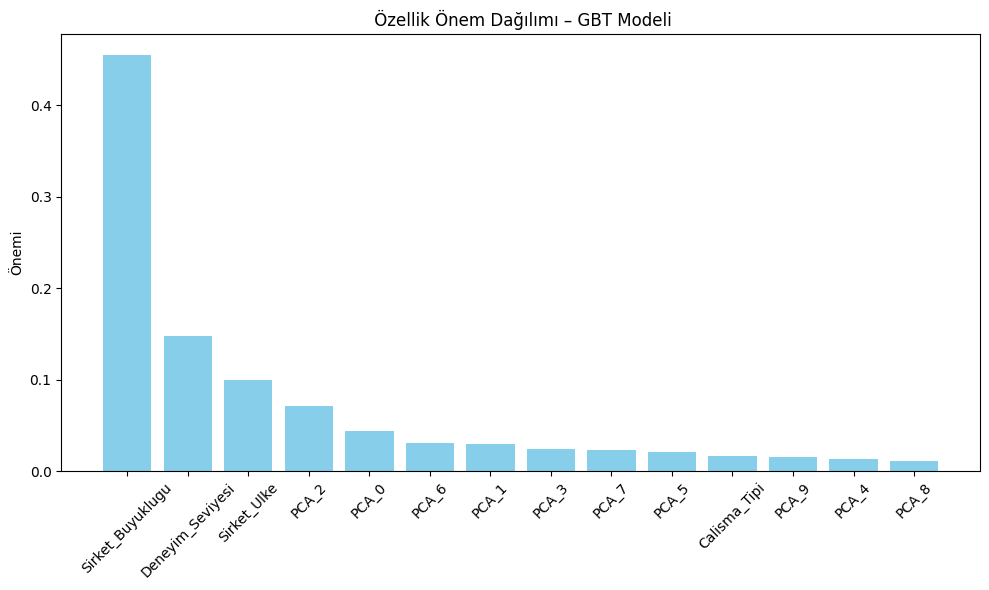

In [50]:
#barplot ile gorsellestirme
plt.figure(figsize=(10, 6))
plt.bar(importance_df["Özellik"], importance_df["Önemi"], color="skyblue")
plt.title(" Özellik Önem Dağılımı – GBT Modeli")
plt.ylabel("Önemi")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


gercek deger ve modelin tahmini icin karsilastirma yapilacak

In [51]:
predictions_pd = predictions.select("Log_Maas_USD", "prediction").toPandas()


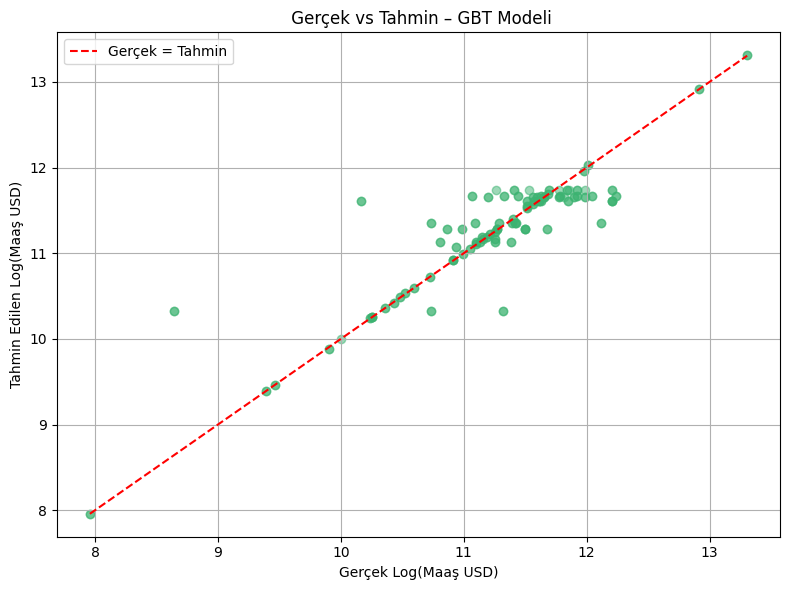

In [52]:
#dagilim grafigi
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(predictions_pd["Log_Maas_USD"], predictions_pd["prediction"], alpha=0.5, color="mediumseagreen")
plt.plot([predictions_pd["Log_Maas_USD"].min(), predictions_pd["Log_Maas_USD"].max()],
         [predictions_pd["Log_Maas_USD"].min(), predictions_pd["Log_Maas_USD"].max()],
         color="red", linestyle="--", label="Gerçek = Tahmin")

plt.title(" Gerçek vs Tahmin – GBT Modeli")
plt.xlabel("Gerçek Log(Maaş USD)")
plt.ylabel("Tahmin Edilen Log(Maaş USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
